In [1]:
from pathlib import Path
desktop_path = Path.home() / "Desktop"
import sys # https://stackoverflow.com/questions/4383571/importing-files-from-different-folder
sys.path.insert(1, rf'{desktop_path}\RA\penicilin\Libaries')

import main as m


In [2]:
from reload_lib import reload_lib as rl


In [3]:
import pandas as pd



In [4]:
init = m.main()
pen_cf_path = Path.joinpath(init.path_github, "data", r"penicillin_impact_factors.xlsx")

In [5]:
with pd.ExcelFile(pen_cf_path) as excel_file:
            # Get the sheet names
            sheet_names = excel_file.sheet_names
sheet_names

['FETP', 'METP', 'TETP', 'HTP']

In [6]:
penicillin_amount = {
    "G" : 600*10e-6,
    "V" : 660*10e-6
}

penicillin_amount

{'G': 0.006, 'V': 0.006600000000000001}

In [7]:
import re 

In [8]:
impact = pd.read_excel(init.LCIA_results, index_col=0)
impact.columns = [i[2] for i in init.lcia_impact_method()]
impact = impact[[col for col in impact.columns if any(c in col for c in sheet_names)]]
htpc = impact.columns[-2]
htpcn = impact.columns[-1]

# # Add col1 and col2 into a new column
impact["Total " + re.sub(" \(.*\)","",htpcn)] = impact[htpc] + impact[htpc]
impact = impact.drop(columns=[htpc, htpcn])
impact.columns = [re.sub(" \(.*\)","",col).title() for col in impact.columns]


In [19]:
max_dct = {}
unit_dct = {}
for ic, sheet in enumerate(sheet_names):
    key = impact.columns[ic]
    max_dct[key] = {}
    df = pd.read_excel(pen_cf_path, skiprows=1, sheet_name=sheet)

    unit = df["Unit"].unique()[0]
    
    unit_dct[key] = unit

    idx = [pen for pen in df["API"]]

    cols = [col for col in df.columns if "water" in col or "soil" in col]

    df = df[cols]
    df.index = idx

    # Convert all values to numeric, set errors='coerce' to turn 'n.a' into NaN
    df = df.apply(pd.to_numeric, errors='coerce')

    for idx, row in df.iterrows():
        if row.notna().any():
            max_col = row.idxmax()          # column name with the (first) max
            max_val = row.max()
            max_dct[key].update({idx : {max_col: max_val}})
        else:
            max_dct[key].update({idx : {}})



emissions_cf_df = pd.DataFrame(max_dct)
pen_cf_max_path = Path.joinpath(init.path_github, "data", r"penicillin_impact_factors_max_value.xlsx")
emissions_cf_df.to_excel(pen_cf_max_path)

In [10]:
dct = {}
dct_markers = []
for p, amount in penicillin_amount.items():
    penicillin = [idx for idx in impact.index if p in idx][0]
    dct[penicillin] = {}
    
    for ic, pen_dct in max_dct.items():
        temp = {}
        temp_m = {}
        for pen, d in pen_dct.items():
            temp[pen] = {}
            temp_m[pen] = {}
            for emission, cf in d.items():
                temp[pen].update({emission.replace("  ", " ") : amount*cf + impact.loc[penicillin, ic]})
                temp_m[pen] = emission
                if emission not in dct_markers:
                    dct_markers.append(emission)
            dct[penicillin].update({ic : temp})
dct

{'Penicillin G, defined system': {'Freshwater Ecotoxicity Potential': {'Erythromycin': {'Emissions to freshwater': 0.22439145699448754},
   'Roxythromycin': {'Emissions to freshwater': 0.06413145699448752},
   'Sulfamethoxazole': {'Emissions to freshwater': 0.06689145699448754},
   'Trimethoprim': {'Emissions to freshwater': 0.052311456994487526}},
  'Marine Ecotoxicity Potential': {'Erythromycin': {'Emissions to seawater': 0.08800483796458104},
   'Roxythromycin': {'Emissions to seawater': 0.07251283796458104},
   'Sulfamethoxazole': {'Emissions to seawater': 0.07193683796458104},
   'Trimethoprim': {'Emissions to seawater': 0.07086703796458103}},
  'Terrestrial Ecotoxicity Potential': {'Erythromycin': {'Emissions to natural soil': 2.794375358487227},
   'Roxythromycin': {'Emissions to natural soil': 2.776612358487227},
   'Sulfamethoxazole': {'Emissions to natural soil': 2.778973358487227},
   'Trimethoprim': {'Emissions to natural soil': 2.776604558487227}},
  'Total Human Toxicity 

In [11]:
pd.DataFrame(dct)

,"Penicillin G, defined system","Penicillin V, defined system"
Freshwater Ecotoxicity Potential,{'Erythromycin': {'Emissions to freshwater': 0...,{'Erythromycin': {'Emissions to freshwater': 0...
Marine Ecotoxicity Potential,{'Erythromycin': {'Emissions to seawater': 0.0...,{'Erythromycin': {'Emissions to seawater': 0.0...
Terrestrial Ecotoxicity Potential,{'Erythromycin': {'Emissions to natural soil':...,{'Erythromycin': {'Emissions to natural soil':...
Total Human Toxicity Potential,"{'Erythromycin': {}, 'Roxythromycin': {}, 'Sul...","{'Erythromycin': {}, 'Roxythromycin': {}, 'Sul..."


In [12]:
dct_markers

['Emissions to  freshwater',
 'Emissions to seawater',
 'Emissions to  natural soil']

In [13]:
dct_markers
mlst = ["o", "^", "s"]
mdct = {marker_name.replace("  ", " ") : mlst[n] for n, marker_name in enumerate(dct_markers)}
mdct

{'Emissions to freshwater': 'o',
 'Emissions to seawater': '^',
 'Emissions to natural soil': 's'}

In [14]:
from matplotlib.lines import Line2D
import numpy as np
import matplotlib.pyplot as plt

def set_figure_title(fig):
    fig.suptitle(
        f'Sensitivity analysis of characterization factor for Penicillin',  # Your global title
        fontsize=14, y=1        # y adjusts vertical position
    )

def scaling_and_unit():
    
    scale = 1000
    unit = 'grams of 1,4-DCB-eq'
    
    return scale, unit

def base_car_barchart(data, ax):
    data.plot(
        kind="bar",
        ax=ax,
        colormap="coolwarm",
        # width=0.75,
        zorder=2
        )

def sensitivity_penicillin_cf_scatter_plot(data, dct, col, ax, scale):
    for x, idx in enumerate(data.index):
        df_cf = pd.DataFrame(dct[idx])
        lst = df_cf[col]
        colors = init.color_range(colorname="coolwarm", color_quantity=len(lst)+1)
        colors = colors[1:]
        for c, (s, val) in enumerate(lst.items()):
            
            try:
                # print(x)
                ax.scatter(
                    x=x,
                    y=list(val.values())[0]*scale,
                    color=colors[c],
                    marker=mdct[list(val.keys())[0]],
                    s=10,  # Adjusted marker size
                    zorder=3
                )
            except (IndexError, KeyError):
                pass
    return colors, df_cf

def get_penicillin_handles(colors, df_cf):
    pen_handles = []
    pen_labels = []
    
    for cl, lbl in enumerate(df_cf.index):
        for em, mk in mdct.items():
            pen_handles.append(
                Line2D(
                    [0], [0],
                    marker=mk,
                    linestyle='None',
                    markerfacecolor=colors[cl],   # fill color
                    markeredgecolor=colors[cl],   # outline color
                    markersize=4,
                    label=lbl
                )
            )
            pen_labels.append(f"{lbl} {em.split()[-1]}")

    return pen_handles, pen_labels


def set_legend(axes_counter, ax, colors, df_cf):
    pen_handles, pen_labels = get_penicillin_handles(colors, df_cf)
    if axes_counter == 2:

        # handles, labels = get_handles_and_labels(mdct, pen_handles, df_cf)

        ax.legend(
            pen_handles,
            pen_labels,
            ncol=4,
            bbox_to_anchor=(2.3, -0.12),
            frameon=False
        )
        
    else:
        ax.get_legend().remove()

def set_y_axis_value(axes_counter, ax):
    if axes_counter == 0:
        ax.set_yticks(np.arange(0, 260, 50))
        ax.set_ylim(0, 260)
    elif axes_counter == 1:
        ax.set_yticks(np.arange(0, 105, 20))
        ax.set_ylim(0, 105)
    elif axes_counter == 2:
        ax.set_yticks(np.arange(0, 3100, 500))
        ax.set_ylim(0, 3050)
    elif axes_counter == 3:
        ax.set_yticks(np.arange(0, 155, 25))
        ax.set_ylim(0, 155)

def penicillin_cf_sensitivity_plot():
    width, height, dpi = init.plot_dimensions()

    fig, axes = plt.subplots(2,2, figsize=(width, height), dpi=dpi)

    set_figure_title(fig)

    plt.subplots_adjust(wspace=0.3, hspace=0.35)
    axes = axes.flatten()
    penicillin_treatment_name = ["IV", "Oral"]
    for axes_counter, col in enumerate(impact.columns):

        scale, unit = scaling_and_unit()

        ax = axes[axes_counter]
        data = impact[col].to_frame()*scale

        base_car_barchart(data, ax)
        
        colors, df_cf = sensitivity_penicillin_cf_scatter_plot(data, dct, col, ax, scale)

        set_legend(axes_counter, ax, colors, df_cf)

        ax.set_xticklabels(penicillin_treatment_name, rotation=0)
        ax.set_title(col)
        ax.set_ylabel(unit)
        ax.grid(axis='y', linestyle='--', alpha=0.7, zorder=-0)
        set_y_axis_value(axes_counter, ax)
    output_file = init.join_path(init.figure_folder, f"penicillin_cf_sensitivity.png")
    plt.savefig(output_file, dpi=dpi, format='png', bbox_inches='tight')

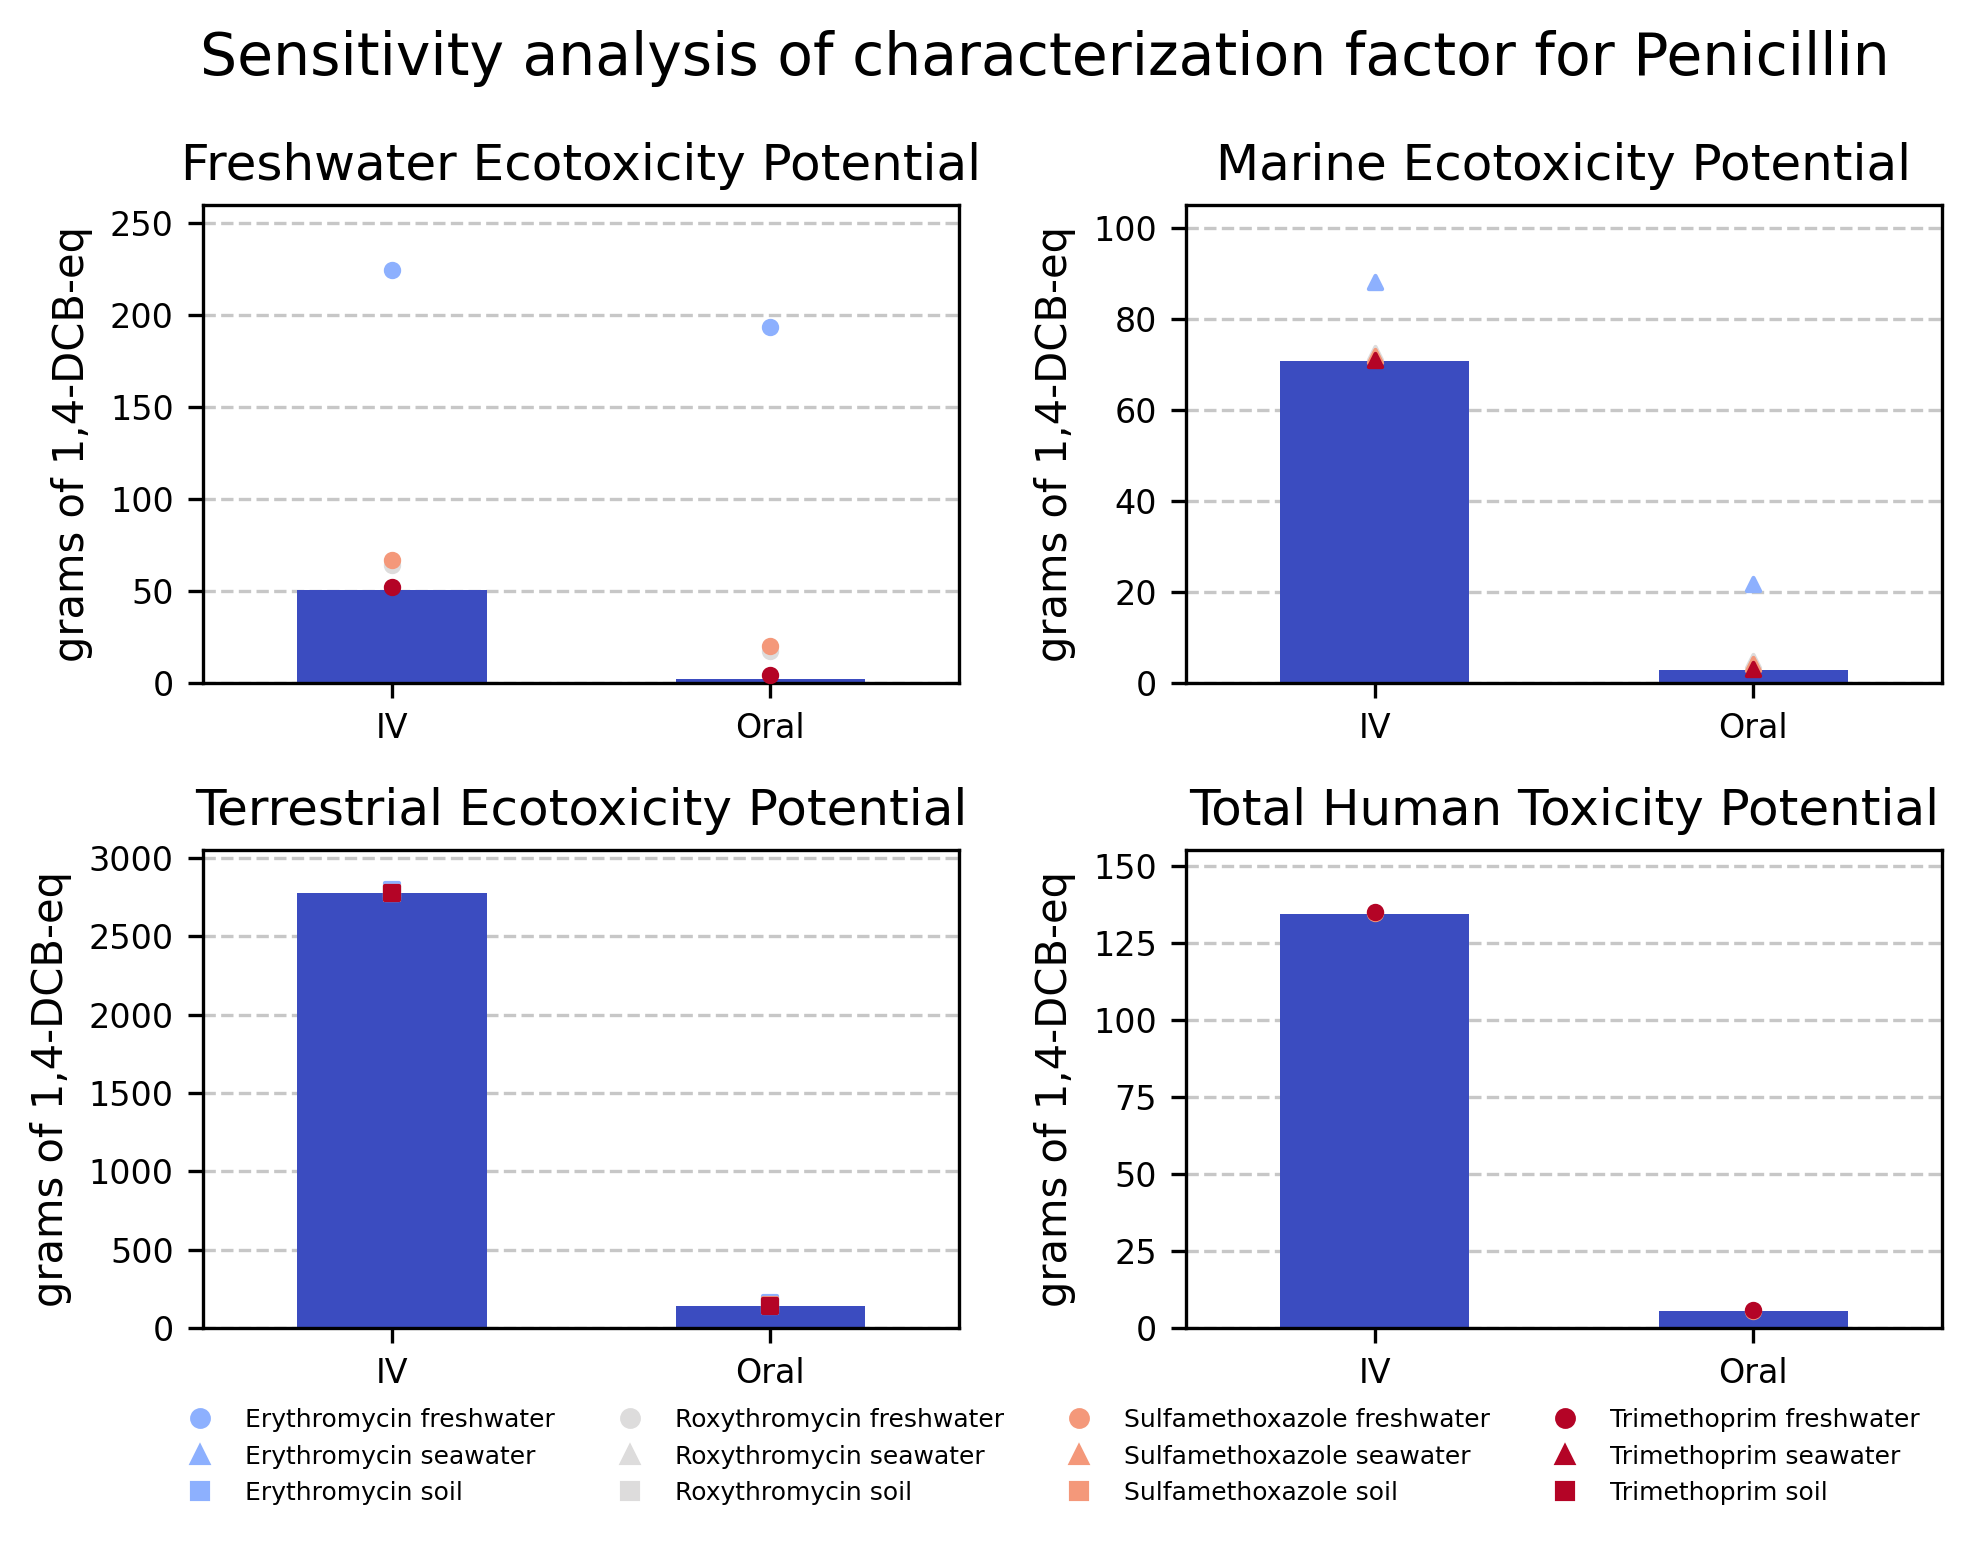

In [548]:
import matplotlib.pyplot as plt
rl(m)
init =m.main()
width, height, dpi = init.plot_dimensions()

fig, axes = plt.subplots(2,2, figsize=(width, height), dpi=dpi)

set_figure_title(fig)

plt.subplots_adjust(wspace=0.3, hspace=0.35)
axes = axes.flatten()
penicillin_treatment_name = ["IV", "Oral"]
for axes_counter, col in enumerate(impact.columns):

    scale, unit = scaling_and_unit()

    ax = axes[axes_counter]
    data = impact[col].to_frame()*scale

    base_car_barchart(data, ax)
    
    colors, df_cf = sensitivity_penicillin_cf_scatter_plot(data, dct, col, ax, scale)

    set_legend(axes_counter, ax, colors, df_cf)

    ax.set_xticklabels(penicillin_treatment_name, rotation=0)
    ax.set_title(col)
    ax.set_ylabel(unit)
    ax.grid(axis='y', linestyle='--', alpha=0.7, zorder=-0)
    set_y_axis_value(axes_counter, ax)
output_file = init.join_path(init.figure_folder, f"penicillin_cf_sensitivity.png")
plt.savefig(output_file, dpi=dpi, format='png', bbox_inches='tight')


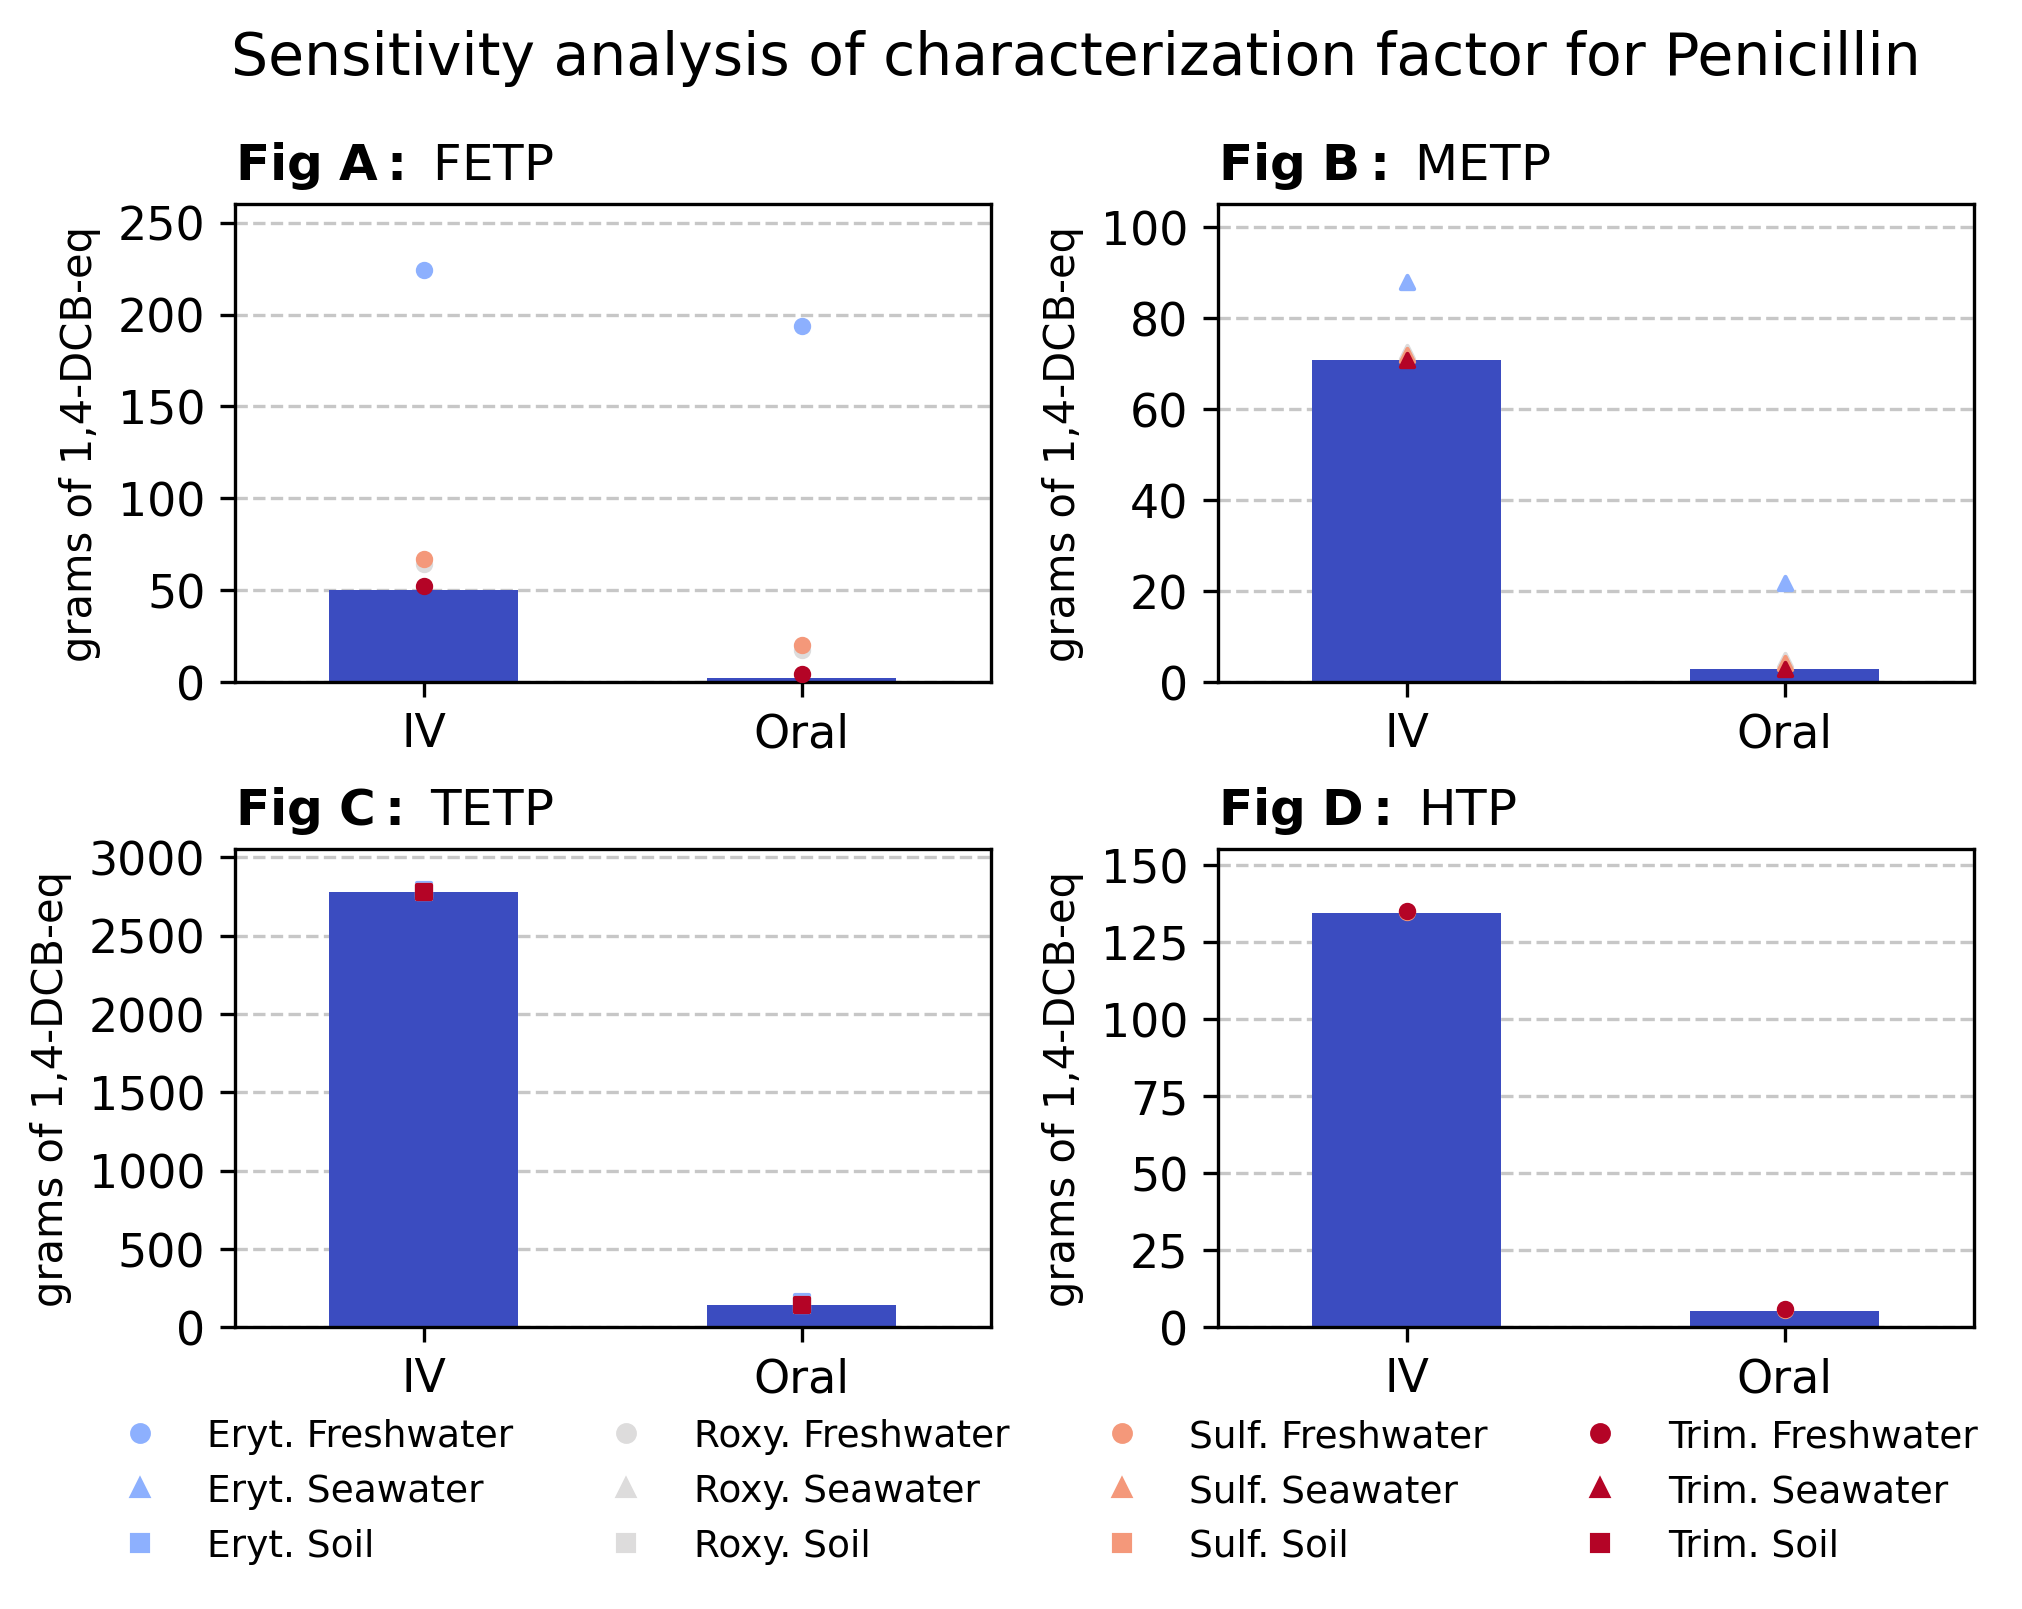

In [28]:
import penicillin_cf_sensitivity as pcs
rl([m, pcs])

pcs.penicillin_cf_sensitivity_plot()

In [38]:
max_dct, impact =  pcs.max_penicillin_cf()
emissions_dct, emissions_lst = pcs.get_penicillin_cf_impact()

In [30]:
impact

,Freshwater Ecotoxicity Potential,Marine Ecotoxicity Potential,Terrestrial Ecotoxicity Potential,Total Human Toxicity Potential
"Penicillin G, defined system",0.050391,0.070725,2.776495,0.134363
"Penicillin V, defined system",0.002190,0.002812,0.142358,0.005425


In [68]:
diff_dct = {}
for idx in impact.index:
    dataframe = pd.DataFrame(emissions_dct[idx])
    diff = pd.DataFrame(emissions_dct[idx])
    for col in impact.columns:
        for edx, row in dataframe.iterrows():
            try:
                val = list(row[col].values())[0]
                og = impact.loc[idx, col]
                diff.loc[edx, col] = '{:.2f}%'.format((val - og)/og*100)
            except IndexError:
                diff.loc[edx, col] = None
    # for   
    diff_dct[idx] = diff

diff_dct["Penicillin G, defined system"]

,Freshwater Ecotoxicity Potential,Marine Ecotoxicity Potential,Terrestrial Ecotoxicity Potential,Total Human Toxicity Potential
Erythromycin,345.30%,24.43%,0.64%,None
Roxythromycin,27.27%,2.53%,0.00%,None
Sulfamethoxazole,32.74%,1.71%,0.09%,0.17%
Trimethoprim,3.81%,0.20%,0.00%,0.39%


In [69]:
diff_dct["Penicillin V, defined system"]

,Freshwater Ecotoxicity Potential,Marine Ecotoxicity Potential,Terrestrial Ecotoxicity Potential,Total Human Toxicity Potential
Erythromycin,8739.43%,675.86%,13.82%,None
Roxythromycin,690.11%,69.93%,0.09%,None
Sulfamethoxazole,828.74%,47.40%,1.91%,4.54%
Trimethoprim,96.44%,5.56%,0.08%,10.61%
